# Financial Consumer Complaint Classification
Qidu Fu, Yuqi Liu, Shixin Pan, Haotian Shen

# 1 Load and understand data

In [ ]:
#connect to Consumer Complaint Database API
#API documentation https://cfpb.github.io/api/ccdb/api.html
import requests
Response = requests.get("https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?field=complaint_what_happened&frm=0&sort=created_date_asc&format=json&no_aggs=false&no_highlight=false&date_received_min=2023-03-01&date_received_max=2024-03-30")
print(Response.status_code)


200


In [2]:
import pandas as pd
# json_path = "C:\\Users\\95254\\Downloads\\complaints-2024-03-31_21_56.json"
# import json

# with open(json_path) as f:
#     Data_Base = json.load(f)

Data_Base = Response.json()
temp = []
for e in Data_Base:
  if e['_source']['complaint_what_happened'] != '':
    temp.append(e['_source'])

del Data_Base

df = pd.DataFrame(temp)
df = df.sort_values(by="complaint_id")
df.head()

#Complaints = Data_Base.aggregations.get('issue')

,product,complaint_what_happened,date_sent_to_company,issue,sub_product,zip_code,tags,complaint_id,timely,consumer_consent_provided,company_response,submitted_via,company,date_received,state,consumer_disputed,company_public_response,sub_issue
180951,"Credit reporting, credit repair services, or o...",While reviewing an updated copy of my credit r...,2023-03-01T12:00:00-05:00,Incorrect information on your report,Credit reporting,07087,None,6626674,Yes,Consent provided,Closed with explanation,Web,"EQUIFAX, INC.",2023-03-01T12:00:00-05:00,NJ,N/A,None,Information belongs to someone else
164226,"Credit reporting, credit repair services, or o...",While reviewing an updated copy of my credit r...,2023-03-01T12:00:00-05:00,Incorrect information on your report,Credit reporting,07087,None,6626675,Yes,Consent provided,Closed with non-monetary relief,Web,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",2023-03-01T12:00:00-05:00,NJ,N/A,Company has responded to the consumer and the ...,Information belongs to someone else
449549,"Credit reporting, credit repair services, or o...",I\n\nw as trying to get a loan to buy a house ...,2023-03-01T12:00:00-05:00,Problem with a credit reporting company's inve...,Credit reporting,92301,None,6626677,Yes,Consent provided,Closed with explanation,Web,"EQUIFAX, INC.",2023-03-01T12:00:00-05:00,CA,N/A,None,Their investigation did not fix an error on yo...
377677,"Credit reporting, credit repair services, or o...",I was trying to get a loan to buy a house and ...,2023-03-01T12:00:00-05:00,Problem with a credit reporting company's inve...,Credit reporting,92301,None,6626678,Yes,Consent provided,Closed with non-monetary relief,Web,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",2023-03-01T12:00:00-05:00,CA,N/A,Company has responded to the consumer and the ...,Their investigation did not fix an error on yo...
385965,"Credit reporting, credit repair services, or o...",XXXX XXXX. Amount : {$35000.00}. XX/XX/2022. I...,2023-03-01T12:00:00-05:00,Improper use of your report,Credit reporting,33169,None,6626679,Yes,Consent provided,Closed with explanation,Web,"EQUIFAX, INC.",2023-03-01T12:00:00-05:00,FL,N/A,None,Reporting company used your report improperly


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469799 entries, 180951 to 129031
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product                    469799 non-null  object
 1   complaint_what_happened    469799 non-null  object
 2   date_sent_to_company       469799 non-null  object
 3   issue                      469799 non-null  object
 4   sub_product                469799 non-null  object
 5   zip_code                   469799 non-null  object
 6   tags                       45450 non-null   object
 7   complaint_id               469799 non-null  object
 8   timely                     469799 non-null  object
 9   consumer_consent_provided  469799 non-null  object
 10  company_response           469796 non-null  object
 11  submitted_via              469799 non-null  object
 12  company                    469799 non-null  object
 13  date_received              469799 non-null  

In [4]:
df['issue'].value_counts()

issue
Incorrect information on your report                                                140104
Improper use of your report                                                         101468
Problem with a credit reporting company's investigation into an existing problem     55545
Problem with a company's investigation into an existing problem                      43060
Attempts to collect debt not owed                                                    16626
                                                                                     ...  
Issue with income share agreement                                                        8
Problems receiving the advance                                                           8
Was approved for a loan, but didn't receive money                                        5
Property was damaged or destroyed property                                               1
Property was sold                                                                   

In [ ]:
# For exmperiemnt purpose, uncomment the following line of code
# df = df.sample(20000, random_state=600)

# 2 Preprocess data

Note: The preprocessing section is mostly based on Prof. Kumarawadu's Preprocessing.ipynb and slightly adopts code from Qidu Fu's assignment 3 for CIS 600.

In [5]:
# import libraries for preprocessing
import nltk
import re
import string

#nltk.download('all', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [6]:
# drop nan and duplicated rows
def drop_nan(df):
    return df.dropna(subset=['complaint_what_happened', 'issue'], how='any')

def drop_duplicate(df):
    return df.drop_duplicates(subset=['complaint_id'])

df = drop_nan(df)
print('df.shape: dropnan', df.shape)
df = drop_duplicate(df)
print('df.shape: drop_duplicates', df.shape)
print(df.head(3))

df.shape: dropnan (469799, 18)
df.shape: drop_duplicates (469799, 18)
                                                  product  \
180951  Credit reporting, credit repair services, or o...   
164226  Credit reporting, credit repair services, or o...   
449549  Credit reporting, credit repair services, or o...   

                                  complaint_what_happened  \
180951  While reviewing an updated copy of my credit r...   
164226  While reviewing an updated copy of my credit r...   
449549  I\n\nw as trying to get a loan to buy a house ...   

             date_sent_to_company  \
180951  2023-03-01T12:00:00-05:00   
164226  2023-03-01T12:00:00-05:00   
449549  2023-03-01T12:00:00-05:00   

                                                    issue       sub_product  \
180951               Incorrect information on your report  Credit reporting   
164226               Incorrect information on your report  Credit reporting   
449549  Problem with a credit reporting company's inve

In [7]:
# select the columns relevant to the objectives of the project
df_selected = df[['complaint_what_happened', 'issue']]
print('df_selected.shape: ')
print(df_selected.shape)
del df

df_selected.shape: 
(469799, 2)


In [9]:
# lower case the text and remove punctuation
# lower case function
# The next 4 lines of code are based on Prof. Kumarawadu's Preprocessing.ipynb

# Define the global punctuation variable to avoid multiple initiations
PUNCTUATION_FOR_REMOVAL = string.punctuation

# Remove punctuation function
def punctuation_helper(text):
    if text is not None:
        return text.translate(str.maketrans('', '', PUNCTUATION_FOR_REMOVAL))
    return text

# Lowercase and remove special characters function
def special_helper(text):
    if text is None:
        return None
    text = text.replace('\n', '')
    # Lowercase the text
    text = text.lower()
    # Remove "XXXX" placeholders
    text = re.sub(r'\bXXXX\b', '', text, flags=re.IGNORECASE)
    # Remove dates in the form of XX/XX/XXXX or similar variations
    text = re.sub(r'\bXX/XX/\d{4}\b', '', text)
    # Remove monetary values
    text = re.sub(r'\{\$[\d,]+\.\d{2}\}', '', text, flags=re.IGNORECASE)
    # Remove non-English letters characters, such as $, and keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove consecutive occurrences of 'x' more than 2 times
    text = re.sub(r'(x{3,})', '', text)
    # Replace multiple consecutive spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Function to lowercase, remove punctuation, and special characters
def lowercase_punctuation_and_special(df, punct_fn, spec_fn):
    for col in df.columns:
        if df[col].dtype == 'object':  # Check if column is of object type
            df[col] = df[col].astype(str).apply(punct_fn).apply(spec_fn)
    return df

print(df_selected.head())
df_selected = lowercase_punctuation_and_special(df_selected, punctuation_helper, special_helper)
print('\n')
print('---------------------------after processing --------------------- ')
print('\n')
print('df_selected.shape: lower_case/remove punctuation', df_selected.shape)
print(df_selected.head())

                                  complaint_what_happened  \
180951  While reviewing an updated copy of my credit r...   
164226  While reviewing an updated copy of my credit r...   
449549  I\n\nw as trying to get a loan to buy a house ...   
377677  I was trying to get a loan to buy a house and ...   
385965  XXXX XXXX. Amount : {$35000.00}. XX/XX/2022. I...   

                                                    issue  
180951               Incorrect information on your report  
164226               Incorrect information on your report  
449549  Problem with a credit reporting company's inve...  
377677  Problem with a credit reporting company's inve...  
385965                        Improper use of your report  


---------------------------after processing --------------------- 


df_selected.shape: lower_case/remove punctuation (469799, 2)
                                  complaint_what_happened  \
180951  while reviewing an updated copy of my credit r...   
164226  while revie

In [10]:
# remove stop words
# the next 3 lines of code are based on Prof. Kumarawadu's Preprocessing.ipynb
STOPWORDS = set(stopwords.words('english'))
def remove_stopword(text):
    return ' '.join(token for token in text.split() if token not in STOPWORDS)

def apply_processing_to_all_cols(df, processing_fn):
    for col in df.columns:
        df[col] = df[col].apply(processing_fn)
    return df

df_selected = apply_processing_to_all_cols(df_selected, remove_stopword)
print('remove stop words --------------')
print(df_selected.head(3))

remove stop words --------------
                                  complaint_what_happened  \
180951  reviewing updated copy credit report discovere...   
164226  reviewing updated copy credit report discovere...   
449549  iw trying get loan buy house checked credit re...   

                                                    issue  
180951                       incorrect information report  
164226                       incorrect information report  
449549  problem credit reporting companys investigatio...  


In [11]:
# drop nan if stop word removal creats nan
df_selected = drop_nan(df_selected)
print('df_selected.shape: dropnan', df_selected.shape)

df_selected.shape: dropnan (469799, 2)


In [12]:
# Remove short and long words
def remove_short_long_word(text, min_length=3, max_length=15):
    return ' '.join(word for word in text.split()
                        if min_length <= len(word) <= max_length)
df_selected['complaint_what_happened'] = df_selected['complaint_what_happened'].apply(remove_short_long_word)
print('Remove short/long words done')

Remove short/long words done


In [13]:
# Stem and lemmatize words
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()
def stem_and_lemmatize(text):
  tokens = nltk.word_tokenize(text)
  tokens = [STEMMER.stem(word) for word in tokens]
  text = ' '.join(LEMMATIZER.lemmatize(word) for word in tokens)
  return text

df_selected = apply_processing_to_all_cols(df_selected, stem_and_lemmatize)
print('stem and lemmatize word --------------')

stem and lemmatize word --------------


In [14]:
df_selected.head()

,complaint_what_happened,issue
180951,review updat copi credit report discov credit ...,incorrect inform report
164226,review updat copi credit report discov credit ...,incorrect inform report
449549,tri get loan buy hous check credit report noti...,problem credit report compani investig exist p...
377677,tri get loan buy hous check credit report noti...,problem credit report compani investig exist p...
385965,amount 3500000 2022 reach compani correct issu...,improp use report


In [15]:
# from: https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [16]:
# This code block is based on Prof. Kumarawadu's Preprocessing.ipynb

# Remove emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

df_selected = apply_processing_to_all_cols(df_selected, remove_emoticons)
print('remove emoticons --------------')

remove emoticons --------------


In [17]:
# This code block is based on Prof. Kumarawadu's Preprocessing.ipynb

# Remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df_selected = apply_processing_to_all_cols(df_selected, remove_emoji)
print('Emojis removal done!')

Emojis removal done!


In [ ]:
# install pyspellchecker if needed
!pip install pyspellchecker

In [18]:
# This code block is based on Prof. Kumarawadu's Preprocessing.ipynb
from spellchecker import SpellChecker

CHECKER = SpellChecker()
def correct_spelling(text):
    corrected_words = []
    misspelled_words = CHECKER.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            correction = CHECKER.correction(word)
            corrected_words.append(correction if correction is not None else word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

#df_selected = apply_processing_to_all_cols(df_selected, correct_spelling)
print('Spell checking done!')

Spell checking done!


# 3 Engineer and vectorize features

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch

c:\Users\95254\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Vectorize the text through bert embedding

# Load BERT-Mini model and tokenizer outside the function
BERT_TOKENIZER = AutoTokenizer.from_pretrained('google/bert_uncased_L-4_H-256_A-4')
BERT_MODEL = AutoModel.from_pretrained('google/bert_uncased_L-4_H-256_A-4')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BERT_MODEL.to(device)

BERT_MODEL.eval()  # Set model to evaluation mode

# Define the Pandas UDF for generating BERT embeddings
def get_embedding_batch(texts: pd.Series) -> pd.Series:
    inputs = BERT_TOKENIZER(texts, return_tensors='pt',
                            padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = BERT_MODEL(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    embeddings_flat = [embedding.flatten() for embedding in embeddings]
    return pd.Series(embeddings_flat)

df_selected['complaint_what_happened_vec'] = df_selected['complaint_what_happened'].apply(get_embedding_batch)
print('*' * 10, 'complaint embedding got!', '*' * 10)
df_selected['issue_vec'] = df_selected['issue'].apply(get_embedding_batch)
print('*' * 10, 'issue embedding got!', '*' * 10)

********** complaint embedding got! **********
********** issue embedding got! **********


# 4 Model

## 4.1 Use unsupervised learning to create labels

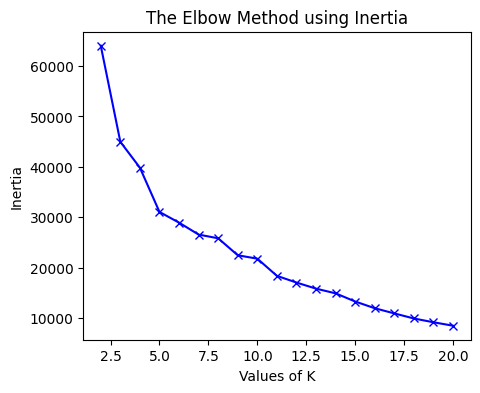

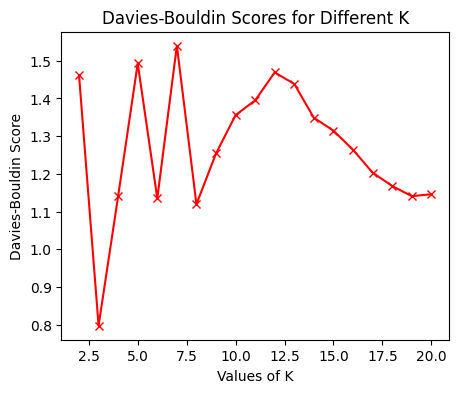

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# Plot the inertia graph
def plot_inertia(inertia_list):
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, len(inertia_list)+2), inertia_list, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

# Plot the Davies-Bouldin scores
def plot_davies_bouldin(davies_lst):
    plt.figure(figsize=(5, 4))
    plt.plot(range(2, len(davies_lst)+2), davies_lst, 'rx-')
    plt.xlabel('Values of K')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Scores for Different K')
    plt.show()

# use the Elbow method to determine the best k and plot Davies-Bouldin scores
def get_elbow_and_davies_bouldin(m, corpus):
    inertia_lst = []
    davies_lst = []
    for i in range(2, m+1):
        model = KMeans(n_clusters=i, n_init='auto', random_state=600)
        model.fit(corpus)

        inertia = model.inertia_
        inertia_lst.append(inertia)

        davies = davies_bouldin_score(corpus, model.labels_)
        davies_lst.append(davies)
    return inertia_lst, davies_lst

def plot_inertia_and_davies_bouldin(m, corpus):
    inertia_lst, davies_lst = get_elbow_and_davies_bouldin(m, corpus)
    plot_inertia(inertia_lst)
    plot_davies_bouldin(davies_lst)

norm_issue_vec = normalize(np.stack(df_selected['issue_vec'].values), norm='l2')
plot_inertia_and_davies_bouldin(20, norm_issue_vec)
del norm_issue_vec


In [26]:
K = 8
kmeans_model = KMeans(n_clusters=K, n_init='auto', random_state=600)
kmeans_model.fit(df_selected['issue_vec'].tolist())
df_selected['label'] = kmeans_model.labels_
df_selected.columns

Index(['complaint_what_happened', 'issue', 'complaint_what_happened_vec',
       'issue_vec', 'label'],
      dtype='object')

In [27]:
df_selected['label'].value_counts()

label
0    140104
2    101468
1     87508
4     48086
6     43553
5     25048
3     16626
7      7406
Name: count, dtype: int64

In [28]:
pd.set_option('display.max_colwidth', None)

for label in range(K):
  print('=' * 50)
  print(f"Label {label}:")
  label_rows = df_selected[df_selected['label'] == label].sample(20, random_state=600)  # Sample 20 rows for each label
  print(label_rows['issue'])

LABEL_MAPPING = {'0': 'written notif debt',
                 '1': 'incorrect inform report',
                 '2': 'payment, false statment, illegality',
                 '3': 'company and organizational (investigation) issue',
                 '4': 'improper use of report',
                 '5': 'account and fee',
                 '6': 'attempt collect debt owe',
                 '7': 'loan and struggle'
                 }

Label 0:
280012    incorrect inform report
418985    incorrect inform report
42031     incorrect inform report
12706     incorrect inform report
455767    incorrect inform report
313076    incorrect inform report
128465    incorrect inform report
373739    incorrect inform report
42139     incorrect inform report
323618    incorrect inform report
320825    incorrect inform report
295560    incorrect inform report
276573    incorrect inform report
429581    incorrect inform report
425091    incorrect inform report
22604     incorrect inform report
397124    incorrect inform report
22723     incorrect inform report
385812    incorrect inform report
355826    incorrect inform report
Name: issue, dtype: object
Label 1:
296419                         problem fraud alert secur freez
468971    problem credit report compani investig exist problem
230017                                problem purchas transfer
181808                                     featur term problem
422062    problem credi

## 4.2 Split data into training and testing set

In [29]:
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 50)

df_train, df_test = train_test_split(df_selected.copy(),
                                     test_size=.2,
                                     shuffle=True,
                                     stratify=df_selected['label'],
                                     random_state=0)
print('Train test split done!')

Train test split done!


In [30]:
# This code block is based on Prof. Kumarawadu's Preprocessing.ipynb

# Remove top and bottom 10 frequent words
from collections import Counter

def get_word_frequency(df):
    cnt = Counter()
    for text in df['complaint_what_happened'].values:
        for word in text.split():
            cnt[word] += 1
    return cnt

# Only use the train data to avoid data leakage
cnt = get_word_frequency(df_train)

FREQ_WORDS = set(word for word, _ in cnt.most_common(10))
def remove_top_freq_word(text):
    return ' '.join(word for word in str(text).split() if word not in FREQ_WORDS)

RARE_WORDS = set(word for word, _ in cnt.most_common()[-1:-11:-1])
def remove_bottom_freq_word(text):
    return ' '.join(word for word in str(text).split() if word not in RARE_WORDS)

df_train['complaint_what_happened'] = df_train['complaint_what_happened'].apply(remove_top_freq_word)
df_train['complaint_what_happened'] = df_train['complaint_what_happened'].apply(remove_bottom_freq_word)

df_test['complaint_what_happened'] = df_test['complaint_what_happened'].apply(remove_top_freq_word)
df_test['complaint_what_happened'] = df_test['complaint_what_happened'].apply(remove_bottom_freq_word)

print('Remove top/bottom freq words done!')

Remove top/bottom freq words done!


In [31]:
# See the label class distribution
print('Distribution of each label: ')
df_train['label'].value_counts()

Distribution of each label: 


label
0    112083
2     81174
1     70006
4     38469
6     34842
5     20039
3     13301
7      5925
Name: count, dtype: int64

In [32]:
t = min(df_train['label'].value_counts())
print(t)

def sample_training_set(df):
  sampled_df = pd.DataFrame()  # Initialize an empty DataFrame to store sampled data

  # Iterate over each unique label
  for label in df['label'].unique():
      # Sample k observations for the current label
      label_samples = df[df['label'] == label].sample(t, replace=False)
      # Append the sampled data for the current label to the sampled DataFrame
      sampled_df = pd.concat([sampled_df, label_samples])

  return sampled_df

df_train = sample_training_set(df_train)
print('df_train_resampled.shape: ', df_train.shape)

5925
df_train_resampled.shape:  (47400, 5)


In [33]:
print('df_train.iloc[0, 0].shape')
print('-' * 50)
print(df_train.iloc[0, 2].shape)
print(df_train.shape)
print(df_train['label'].value_counts())
df_train.head()

df_train.iloc[0, 0].shape
--------------------------------------------------
(256,)
(47400, 5)
label
5    5925
0    5925
2    5925
4    5925
6    5925
1    5925
7    5925
3    5925
Name: count, dtype: int64


,complaint_what_happened,issue,complaint_what_happened_vec,issue_vec,label
270421,cash app daughter 1600 2023 repli back love he...,manag account,"[-0.04484793, 0.7630417, 0.26225132, 0.5454871...","[-0.3023518, 0.40197188, -0.046634406, 0.57416...",5
354107,comen capit bank part bread financi creat late...,fee interest,"[-0.13211656, 0.8673024, 0.13031176, 0.6029191...","[0.26706508, 1.0385609, -0.06304949, 0.1668293...",5
282889,file disput transact approv done author user m...,manag account,"[-0.011347123, 0.87910306, 0.2954558, 0.581152...","[-0.3023518, 0.40197188, -0.046634406, 0.57416...",5
277285,write express deep concern frustrat regard fra...,manag account,"[-0.029378887, 0.80674624, 0.1320233, -0.16610...","[-0.3023518, 0.40197188, -0.046634406, 0.57416...",5
393480,got charg random fee chase date 2023 howev nev...,manag account,"[0.05498091, 0.7336454, 0.47070643, 1.1999133,...","[-0.3023518, 0.40197188, -0.046634406, 0.57416...",5


In [34]:
print('df_test.iloc[0, 3].shape')
print('-' * 50)
print(df_test.iloc[0, 3].shape)
print(df_test.shape)
df_test.head()

df_test.iloc[0, 3].shape
--------------------------------------------------
(256,)
(93960, 5)


,complaint_what_happened,issue,complaint_what_happened_vec,issue_vec,label
207189,made time request late mark updat reflect accu...,problem compani investig exist problem,"[0.047795344, 0.56333476, 0.43446046, -0.11281...","[-0.3270617, 0.92367864, 0.7190182, 0.42857772...",6
203139,reach ticket need disput remov insur compani t...,incorrect inform report,"[-0.20898862, 0.66865605, 0.14912409, -0.12422...","[-0.23021951, 0.24729185, 0.8284839, 0.0332443...",0
65104,accord fair act list violat feder protect righ...,improp use report,"[0.020253187, 0.98450387, 0.14820243, -0.38507...","[-0.28216514, 0.3804463, 0.4607548, -0.359598,...",2
441049,disappoint happen embarrass clearli either fau...,problem credit report compani investig exist p...,"[-0.06689733, 0.34937695, 0.53052694, 0.745606...","[-0.17669104, 0.9138873, 0.7514434, 0.24135926...",1
409682,financi lender incorrectli sent privat student...,incorrect inform report,"[-0.07873352, 0.772181, 0.28321207, 0.18789494...","[-0.23021951, 0.24729185, 0.8284839, 0.0332443...",0


## 4.3 Use supervised Learning to make predictions

In [35]:
# Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

unigram_tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=5, stop_words='english')
X_train = unigram_tfidf_vectorizer.fit_transform(df_train['complaint_what_happened'].tolist())
X_test = unigram_tfidf_vectorizer.transform(df_test['complaint_what_happened'].tolist())
y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60     28021
           1       0.41      0.13      0.19     17502
           2       0.74      0.64      0.69     20294
           3       0.28      0.59      0.38      3325
           4       0.59      0.63      0.61      9617
           5       0.39      0.91      0.55      5009
           6       0.34      0.65      0.45      8711
           7       0.15      0.51      0.23      1481

    accuracy                           0.52     93960
   macro avg       0.45      0.57      0.46     93960
weighted avg       0.57      0.52      0.51     93960



In [36]:
# SVM
from sklearn.svm import SVC

svm = SVC(class_weight='balanced')
svm.fit(df_train['complaint_what_happened_vec'].tolist(), df_train['label'].tolist())
y_pred = svm.predict(df_test['complaint_what_happened_vec'].tolist())

print(classification_report(df_test['label'].tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.73      0.55      0.62     28021
           1       0.50      0.20      0.29     17502
           2       0.70      0.73      0.71     20294
           3       0.24      0.48      0.32      3325
           4       0.56      0.60      0.58      9617
           5       0.43      0.78      0.55      5009
           6       0.39      0.60      0.48      8711
           7       0.14      0.51      0.22      1481

    accuracy                           0.54     93960
   macro avg       0.46      0.56      0.47     93960
weighted avg       0.59      0.54      0.54     93960



In [37]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(df_train['complaint_what_happened_vec'].tolist(), df_train['label'].tolist())
y_pred = rfc.predict(df_test['complaint_what_happened_vec'].tolist())

print(classification_report(df_test['label'].tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68     28021
           1       0.65      0.28      0.39     17502
           2       0.77      0.75      0.76     20294
           3       0.20      0.51      0.28      3325
           4       0.50      0.59      0.54      9617
           5       0.38      0.73      0.50      5009
           6       0.54      0.64      0.59      8711
           7       0.15      0.61      0.23      1481

    accuracy                           0.58     93960
   macro avg       0.50      0.59      0.50     93960
weighted avg       0.66      0.58      0.59     93960



In [38]:
# Gradient Boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier()
hgbc.fit(df_train['complaint_what_happened_vec'].tolist(), df_train['label'].tolist())
y_pred = hgbc.predict(df_test['complaint_what_happened_vec'].tolist())

print(classification_report(df_test['label'].tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67     28021
           1       0.55      0.31      0.40     17502
           2       0.75      0.75      0.75     20294
           3       0.23      0.50      0.32      3325
           4       0.54      0.58      0.56      9617
           5       0.43      0.75      0.54      5009
           6       0.47      0.64      0.54      8711
           7       0.17      0.60      0.27      1481

    accuracy                           0.58     93960
   macro avg       0.49      0.59      0.51     93960
weighted avg       0.63      0.58      0.59     93960



In [39]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(df_train['complaint_what_happened_vec'].tolist(), df_train['label'].tolist())
y_pred = xgb.predict(df_test['complaint_what_happened_vec'].tolist())

print(classification_report(df_test['label'].tolist(), y_pred))

              precision    recall  f1-score   support

           0       0.80      0.60      0.68     28021
           1       0.57      0.34      0.42     17502
           2       0.78      0.75      0.76     20294
           3       0.24      0.52      0.32      3325
           4       0.55      0.59      0.57      9617
           5       0.43      0.74      0.55      5009
           6       0.48      0.66      0.56      8711
           7       0.18      0.61      0.28      1481

    accuracy                           0.59     93960
   macro avg       0.50      0.60      0.52     93960
weighted avg       0.65      0.59      0.60     93960



In [40]:
# BERT
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

X_train_encodings = BERT_TOKENIZER(df_train['complaint_what_happened'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
X_test_encodings = BERT_TOKENIZER(df_test['complaint_what_happened'].tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')


y_train_tensor = torch.tensor(df_train['label'].tolist())
y_test_tensor = torch.tensor(df_test['label'].tolist())


class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize BERTClassifier
num_classes = K
model = BERTClassifier(BERT_MODEL, num_classes)

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Define number of epochs and batch size
num_epochs = 10
batch_size = 32

# Prepare DataLoader for training
train_dataset = TensorDataset(X_train_encodings['input_ids'],
                              X_train_encodings['attention_mask'],
                              y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


# Define DataLoader for test set
test_dataset = TensorDataset(X_test_encodings['input_ids'],
                             X_test_encodings['attention_mask'],
                             y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits = model(input_ids, attention_mask)
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
print(classification_report(true_labels, predictions))



Epoch 1/10, Loss: 1.4160
Epoch 2/10, Loss: 1.1393
Epoch 3/10, Loss: 1.0504
Epoch 4/10, Loss: 0.9948
Epoch 5/10, Loss: 0.9463
Epoch 6/10, Loss: 0.9053
Epoch 7/10, Loss: 0.8694
Epoch 8/10, Loss: 0.8378
Epoch 9/10, Loss: 0.8041
Epoch 10/10, Loss: 0.7753
              precision    recall  f1-score   support

           0       0.81      0.62      0.70     28021
           1       0.61      0.40      0.48     17502
           2       0.76      0.77      0.77     20294
           3       0.27      0.67      0.38      3325
           4       0.71      0.60      0.65      9617
           5       0.53      0.86      0.65      5009
           6       0.48      0.64      0.54      8711
           7       0.24      0.71      0.36      1481

    accuracy                           0.63     93960
   macro avg       0.55      0.66      0.57     93960
weighted avg       0.68      0.63      0.64     93960



In [41]:
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affi